In [ ]:
# loading & exploring the dataset

import os
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [ ]:
print(os.listdir(DATA_DIR+'/images')[:10])

['48677_2014.jpg', '33914_2011.jpg', '20526_2007.jpg', '60651_2018.jpg', '44570_2013.jpg', '1359_2001.jpg', '60934_2018.jpg', '14650_2006.jpg', '45378_2014.jpg', '58923_2018.jpg']


In [ ]:
# necessary imports

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
# loading dataset with torchvision ImageFolder, applying 64×64 resize/center-crop & Normalize(0.5,0.5,0.5)
# to map pixels to (−1,1), then wrapping in a DataLoader for batching

train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# creating helper functions to denormalize the image tensors & display some sample images from a training batch

#image = ((image * std) + mean) --> transform image back in [0 1] range
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

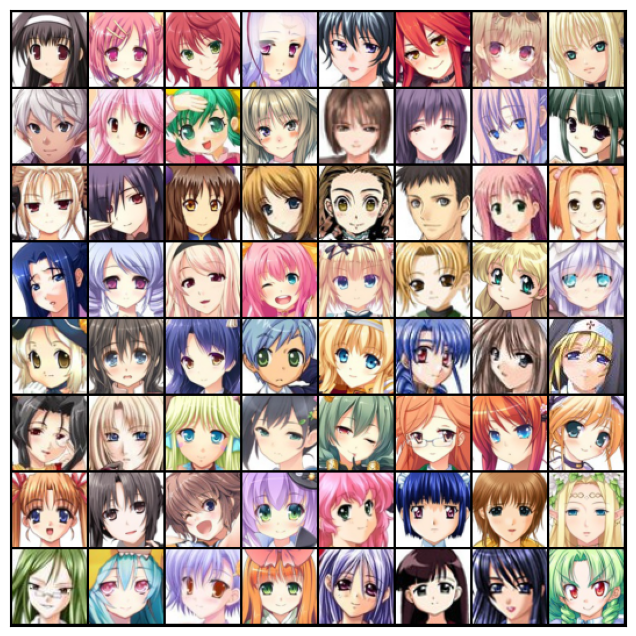

In [ ]:
show_batch(train_dl)

In [ ]:
# use get_default_device() to pick GPU if available, then wrap model/data with to_device()
# & DeviceDataLoader for automatic device placement

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# determining default device as CPU or GPU based on availability

device = get_default_device()
device

device(type='cuda')

In [ ]:
# wrapping the training DataLoader with DeviceDataLoader to auto-transfer
# each batch to the chosen device (be it CPU or GPU)

train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
# defining the discriminator as a CNN using stride-2 convolutions to downsample input images
# & output a single real/fake classification score

discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    # in: 64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    # in: 128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    # in: 256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
# move discriminator model to chosen device

discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
# mapping a random latent tensor (128×1×1) to a 3×28×28 image using ConvTranspose2d (deconvolution) layers

generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


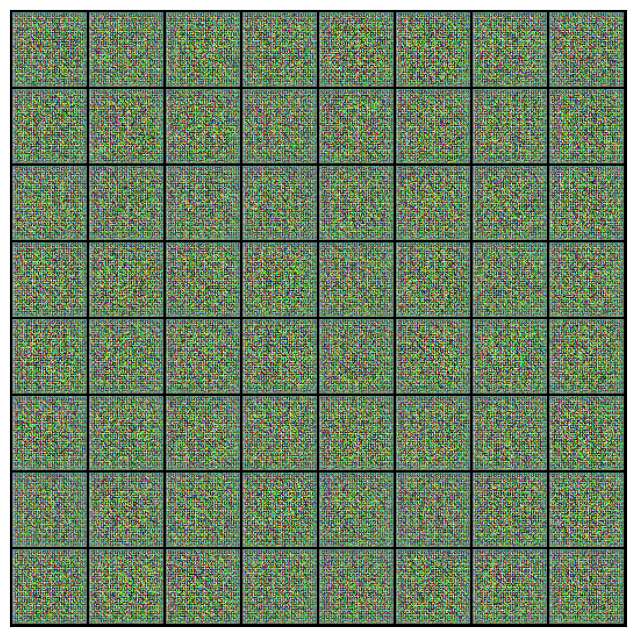

In [ ]:
# generating some outputs using the generator & viewing them as images by transforming and denormalizing the output

xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
# move untrained generator (currently outputting random noise) to selected device

generator = to_device(generator, device)

In [ ]:
# used binary cross-entropy loss (BCE) to train the discriminator for real vs fake image classification

def train_discriminator(real_images, opt_d):
    # clear discriminator gradients
    opt_d.zero_grad()

    # pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # clear generator gradients
    opt_g.zero_grad()

    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
# creating a directory for generator outputs & defining a helper to save image grids for visual monitoring

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
# generated & saved initial sample images from a fixed latent vector to track progress over training

fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


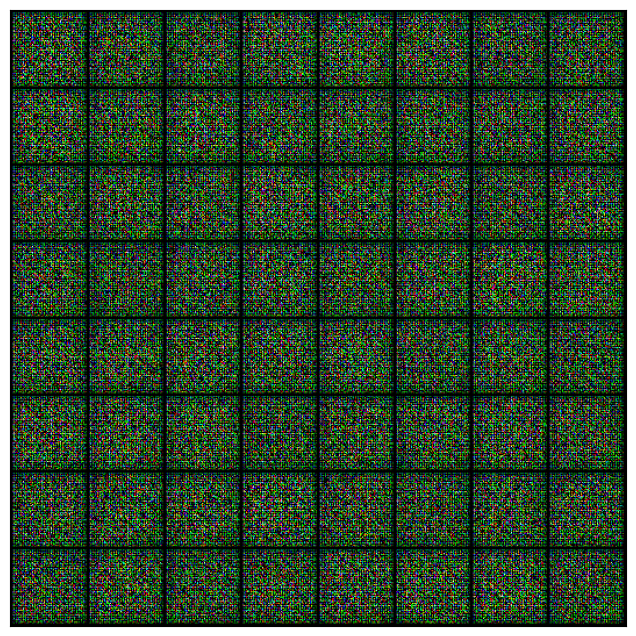

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
# defining a fit() function to alternate discriminator/generator updates using Adam (betas=(0.5,0.999))
# & periodically saving generated image samples for inspection

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Ccreate optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

            # train generator
            loss_g = train_generator(opt_g)

        # record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
# trained the GAN, experimenting with different learning rates to maintain balance between generator and discriminator updates

lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 3.6874, loss_d: 0.9118, real_score: 0.5135, fake_score: 0.0488
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 4.1709, loss_d: 0.3241, real_score: 0.9011, fake_score: 0.1729
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 4.4922, loss_d: 0.2540, real_score: 0.8671, fake_score: 0.0829
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 5.2234, loss_d: 0.2633, real_score: 0.8971, fake_score: 0.1181
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 5.4581, loss_d: 0.6414, real_score: 0.6699, fake_score: 0.0082
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 3.9715, loss_d: 0.2484, real_score: 0.8367, fake_score: 0.0403
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 3.7432, loss_d: 0.2332, real_score: 0.8548, fake_score: 0.0557
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.0805, loss_d: 0.1718, real_score: 0.9673, fake_score: 0.1188
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 5.4186, loss_d: 0.2872, real_score: 0.9590, fake_score: 0.1913
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 4.5437, loss_d: 0.1991, real_score: 0.9088, fake_score: 0.0845
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 4.1531, loss_d: 0.1763, real_score: 0.9161, fake_score: 0.0755
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 3.6409, loss_d: 0.3690, real_score: 0.7480, fake_score: 0.0098
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 3.1783, loss_d: 0.3150, real_score: 0.7896, fake_score: 0.0254
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 2.7236, loss_d: 0.1060, real_score: 0.9947, fake_score: 0.0907
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 3.6539, loss_d: 0.4066, real_score: 0.8533, fake_score: 0.1681
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.2266, loss_d: 0.2644, real_score: 0.8076, fake_score: 0.0118
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 2.7216, loss_d: 0.7491, real_score: 0.5694, fake_score: 0.0174
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 3.9786, loss_d: 0.1747, real_score: 0.9051, fake_score: 0.0541
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.7505, loss_d: 0.1110, real_score: 0.9775, fake_score: 0.0801
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 6.7364, loss_d: 0.4506, real_score: 0.9652, fake_score: 0.2793
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 3.7222, loss_d: 0.1160, real_score: 0.9215, fake_score: 0.0288
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 5.3673, loss_d: 0.2238, real_score: 0.9901, fake_score: 0.1699
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 2.8486, loss_d: 0.4696, real_score: 0.7247, fake_score: 0.0452
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 4.0861, loss_d: 0.0909, real_score: 0.9445, fake_score: 0.0301
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.5743, loss_d: 1.8700, real_score: 0.2216, fake_score: 0.0005
Saving generated-images-0025.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# save model checkpoints

torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

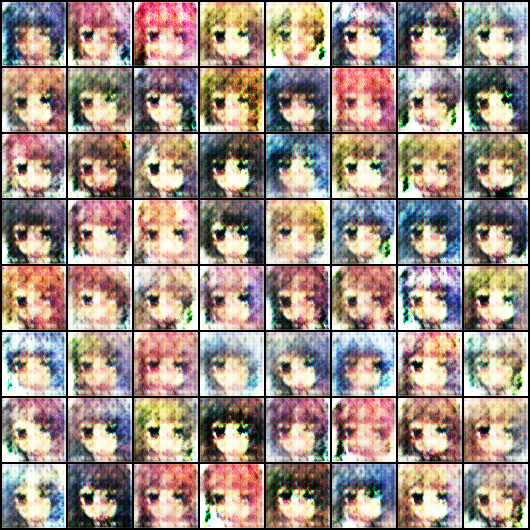

In [ ]:
# how the generated images looked after the 1st, 5th and 10th epochs of training

Image('./generated/generated-images-0001.png')

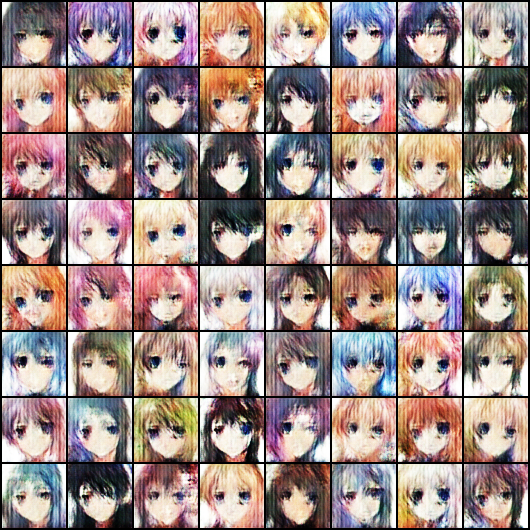

In [ ]:
Image('./generated/generated-images-0005.png')

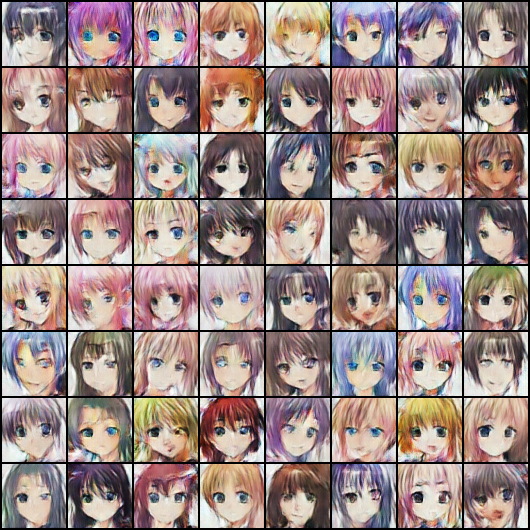

In [ ]:
Image('./generated/generated-images-0010.png')

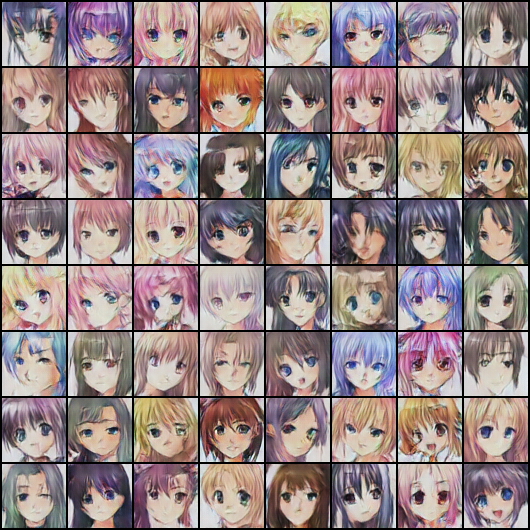

In [ ]:
Image('./generated/generated-images-0020.png')

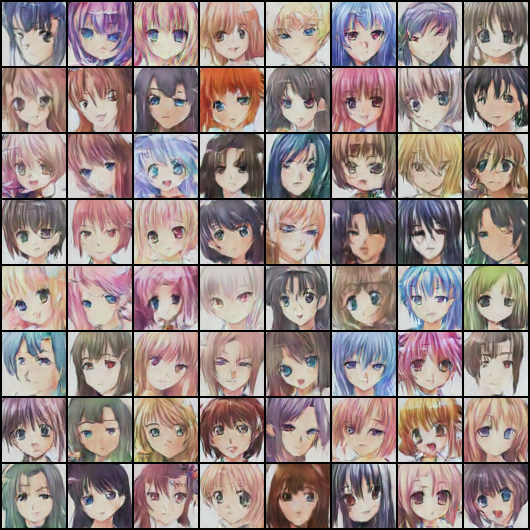

In [ ]:
Image('./generated/generated-images-0025.png')

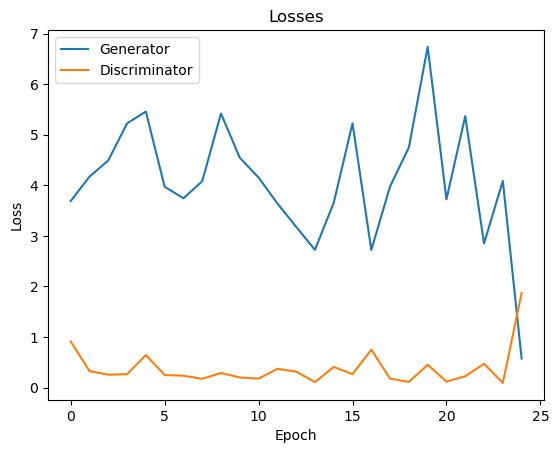

In [ ]:
# ploting generator & discriminator losses over epochs to monitor training stability & convergence

plt.plot(losses_g, label="Generator")
plt.plot(losses_d, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Losses")
plt.show()

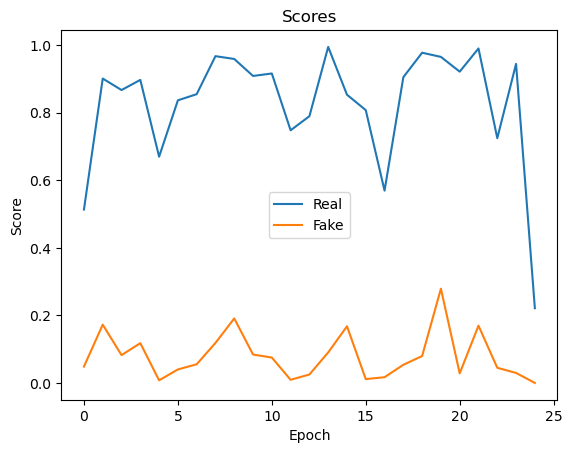

In [ ]:
# ploting discriminator’s real vs fake scores over time to evaluate its performance on actual & generated images

plt.plot(real_scores, label="Real")
plt.plot(fake_scores, label="Fake")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.title("Scores")
plt.show()